# Dataset

## Importer les librairies nécessaires

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import json
import random
import pandas as pd 
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

2025-01-05 19:54:20.441059: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736103260.551171     949 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736103260.591897     949 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 19:54:20.964612: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Analyse des données

Utiliser le fichier d’annotations fourni avec le dataset Data_Herbier_trait_segmentation pour générer des descriptions textuelles des images.

In [3]:
annotations_file = 'annotations-herbier.csv'

In [4]:
## Analyse de la Structure du Fichier Annotations
df = pd.read_csv(annotations_file, sep=';')
print(f"Il y a {len(df)} annotations")
print(f"Les valeurs de 'code' sont : {df['code'].unique()[:3]}")
print(f"Les valeurs de 'epines' sont : {df['epines'].unique()}")
print(f"Les valeurs de 'feuille_ext_acuminee' sont : {df['feuille_ext_acuminee'].unique()}")

Il y a 2530 annotations
Les valeurs de 'code' sont : ['ANG\xa0419,00' 'ANG\xa0430,00' 'ANG\xa02056,00']
Les valeurs de 'epines' sont : [ 1.  0. -1.]
Les valeurs de 'feuille_ext_acuminee' sont : [ 1.  0. -1.]


In [ ]:
# read the csv file and store the data in a list of dictionaries
## On fait correspondre les codes du dataset au nom des images
def get_annotations(annotations_file):
    df = pd.read_csv(annotations_file, sep=';')
    
    df['code'] = df['code'].str.replace("\xa0", "").str.replace(",00", "")  # Exemple : "ANG\xa0419,00" devient 'ANG419'
    df['code'] = df['code'].apply(lambda x: "ANG" + x.split("ANG")[1].zfill(6) if "ANG" in x else x)  # Exemple : "ANG419" devient "ANG000419"
    
    df['epines'] = df['epines'].astype(int)
    df['feuille_ext_acuminee'] = df['feuille_ext_acuminee'].astype(int)
    
    return df

annotations = get_annotations(annotations_file)
print(len(annotations), 'annotations loaded')
annotations.head()

2530 annotations loaded


,code,epines,feuille_ext_acuminee
0,ANG000419,1,1
1,ANG000430,1,0
2,ANG002056,1,0
3,ANG005088,1,0
4,ANG005330,1,1


In [6]:
# Keep only annotations that have a corresponding image in the images folder
annotations = annotations[annotations.apply(lambda row: os.path.exists(f"./images/{row['code']}.jpg"), axis=1)]
print(len(annotations), 'annotations with images')
annotations.head()

102 annotations with images


,code,epines,feuille_ext_acuminee
0,ANG000419,1,1
2,ANG002056,1,0
3,ANG005088,1,0
4,ANG005330,1,1
5,ANG005458,1,1


In [7]:
# list the possible values for thorns and acuminate leaves
print("Epines :", annotations['epines'].unique())
print("Feuille acuminee :", annotations['feuille_ext_acuminee'].unique())

Epines : [1 0]
Feuille acuminee : [ 1  0 -1]


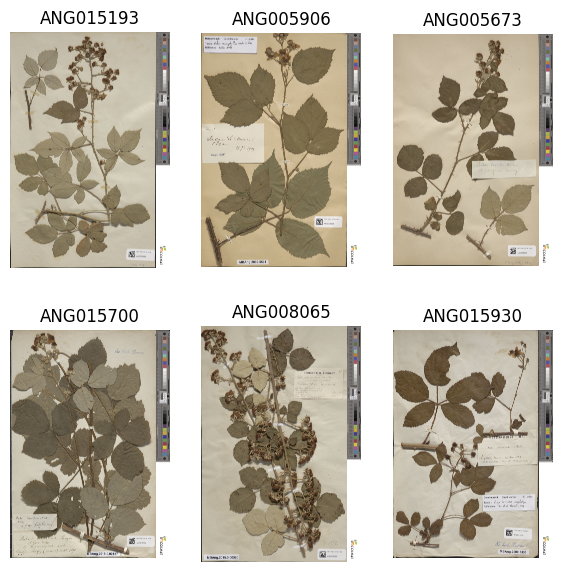

In [8]:
## Plante avec feuille_ext_acuminee (haut dessus) et sans feuille_ext_acuminee (en dessous)
plt.figure(figsize=(7, 14))
feuille_plus_sample = annotations[annotations['feuille_ext_acuminee'] == 1].sample(3)
feuille_zero_sample = annotations[annotations['feuille_ext_acuminee'] == 0].sample(3)
for i in range(3):
    plant_plus = feuille_plus_sample.iloc[i]
    plant_zero = feuille_zero_sample.iloc[i]
    img_plus = cv2.cvtColor(cv2.imread(f"images/{plant_plus['code']}.jpg"), cv2.COLOR_BGR2RGB)
    img_zero = cv2.cvtColor(cv2.imread(f"images/{plant_zero['code']}.jpg"), cv2.COLOR_BGR2RGB)
    plt.subplot(1, 3, 1+i)
    plt.imshow(img_plus)
    plt.title(plant_plus['code'])
    plt.axis('off')
    plt.subplot(2, 3, 1+i)
    plt.imshow(img_zero)
    plt.title(plant_zero['code'])
    plt.axis('off')

Les trois images du haut ont `feuille_ext_acuminee = 1` et les trois du bas `feuille_ext_acuminee = 0`. On en déduit que :
- 1 indique la présence de feuilles acuminées
- 0 indique l'absence
- -1 indique l'indétermination

De même pour les épines :
- 1 s'il y a des épines
- 0 s'il n'y en a pas

In [9]:
# convert '1' and '0' to True and False
annotations['epines'] = annotations['epines'].astype(bool)
annotations['feuille_ext_acuminee'] = annotations['feuille_ext_acuminee'].apply(lambda x: True if x == 1 else False)
annotations.head()

,code,epines,feuille_ext_acuminee
0,ANG000419,True,True
2,ANG002056,True,False
3,ANG005088,True,False
4,ANG005330,True,True
5,ANG005458,True,True


In [10]:
def get_description(row):
  epines = 'with' if row['epines'] else 'without'
  feuille_ext_acuminee = 'are acuminate' if row['feuille_ext_acuminee'] else 'are not acuminate'
  return f"A plant {epines} thorns. Its leaves {feuille_ext_acuminee}."

annotations['description'] = annotations.apply(get_description, axis=1)
annotations.head()

,code,epines,feuille_ext_acuminee,description
0,ANG000419,True,True,A plant with thorns. Its leaves are acuminate.
2,ANG002056,True,False,A plant with thorns. Its leaves are not acumin...
3,ANG005088,True,False,A plant with thorns. Its leaves are not acumin...
4,ANG005330,True,True,A plant with thorns. Its leaves are acuminate.
5,ANG005458,True,True,A plant with thorns. Its leaves are acuminate.


## Data Augmentation

In [11]:
## D'abord on retaille les images
for img in random.choices(os.listdir('images'),k=10):
    image = cv2.imread(f"images/{img}")
    h, w, c = image.shape
    print(f"Shape : ({w}, {h}, {c}) ; Ratio {round(h/w,2)}")

Shape : (3845, 5718, 3) ; Ratio 1.49
Shape : (3955, 5761, 3) ; Ratio 1.46
Shape : (4245, 6211, 3) ; Ratio 1.46
Shape : (6405, 9261, 3) ; Ratio 1.45
Shape : (3795, 5541, 3) ; Ratio 1.46
Shape : (6401, 9151, 3) ; Ratio 1.43
Shape : (6467, 9284, 3) ; Ratio 1.44
Shape : (4219, 6084, 3) ; Ratio 1.44
Shape : (3815, 5626, 3) ; Ratio 1.47
Shape : (6865, 9934, 3) ; Ratio 1.45


Les images sont très grandes et de tailles variées (mais toujours à peu près au même format 1.45). Pour les uniformiser, on les divise en deux et on ajuste la taille de chaque moitié pour avoir de images en 1024x1024.

In [12]:
# expand the dataset by reducing each image to 2 patches of size 1024x1024
def resize_image(images_list):
    os.makedirs('augmented_images', exist_ok=True)

    for img in images_list:
        image = cv2.imread(f"images/{img}")
        patch_height = image.shape[0] // 2
        top_img = cv2.resize(image[:patch_height], (1024, 1024))
        bottom_img =  cv2.resize(image[patch_height:], (1024, 1024))

        top_img_pil = Image.fromarray(cv2.cvtColor(top_img, cv2.COLOR_BGR2RGB))
        bottom_img_pil = Image.fromarray(cv2.cvtColor(bottom_img, cv2.COLOR_BGR2RGB))

        image_name = img.replace(".jpg", "")
        top_img_pil.save(f"augmented_images/{image_name}_1.jpg", "JPEG")
        bottom_img_pil.save(f"augmented_images/{image_name}_2.jpg", "JPEG")

    return 0

resize_image(os.listdir('images'))
print(len(os.listdir('augmented_images')))

320


In [13]:
annotations1 = annotations.copy()
annotations1['code'] = annotations['code'].apply(lambda x: x + "_1")
annotations2 = annotations.copy()
annotations2['code'] = annotations['code'].apply(lambda x: x + "_2")

annotations = pd.concat([annotations1, annotations2], ignore_index=True)
print(len(annotations))
annotations.head()

204


,code,epines,feuille_ext_acuminee,description
0,ANG000419_1,True,True,A plant with thorns. Its leaves are acuminate.
1,ANG002056_1,True,False,A plant with thorns. Its leaves are not acumin...
2,ANG005088_1,True,False,A plant with thorns. Its leaves are not acumin...
3,ANG005330_1,True,True,A plant with thorns. Its leaves are acuminate.
4,ANG005458_1,True,True,A plant with thorns. Its leaves are acuminate.


In [14]:
print(annotations.loc[0])
print(annotations.loc[102])

code                                                       ANG000419_1
epines                                                            True
feuille_ext_acuminee                                              True
description             A plant with thorns. Its leaves are acuminate.
Name: 0, dtype: object
code                                                       ANG000419_2
epines                                                            True
feuille_ext_acuminee                                              True
description             A plant with thorns. Its leaves are acuminate.
Name: 102, dtype: object


In [15]:
# count number of plants with and without thorns
## Maintenant les images sont pretes mais les classes ne sont pas equilibrées
with_epines = annotations[annotations['epines'] == True]
without_epines = annotations[annotations['epines'] == False]
with_feuille_ext_acuminee = annotations[annotations['feuille_ext_acuminee'] == True]
without_feuille_ext_acuminee = annotations[annotations['feuille_ext_acuminee'] == False]

print(len(with_epines), 'plants with thorns')
print(len(without_epines), 'plants without thorns')
print(len(with_feuille_ext_acuminee), 'plants with acuminate leaves')
print(len(without_feuille_ext_acuminee), 'plants without acuminate leaves')

198 plants with thorns
6 plants without thorns
44 plants with acuminate leaves
160 plants without acuminate leaves


/root/anaconda3/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1736103290.240099     949 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


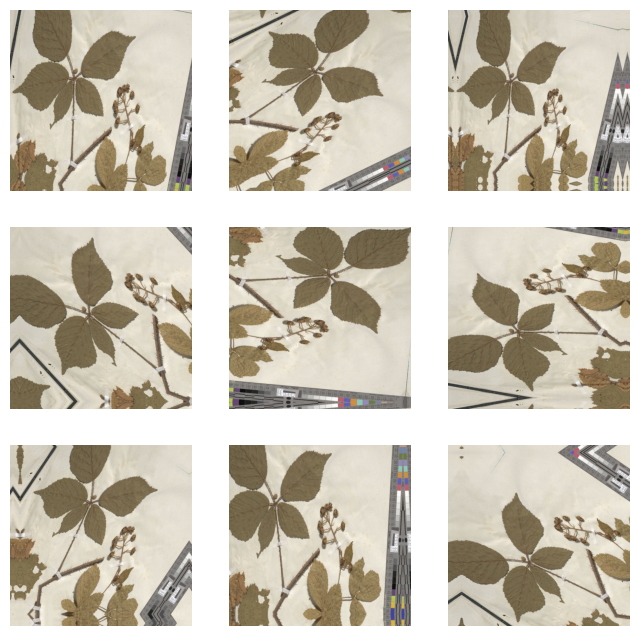

In [16]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.3, input_shape=(1024, 1024, 3)),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomZoom(0.1),
])


image = cv2.imread('augmented_images/AUR03928_1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
image = tf.convert_to_tensor(image) # Add batch dimension as TensorFlow expects a batch of images
image = tf.expand_dims(image, 0)  # Shape: (1, 1024, 1024, 3)

plt.figure(figsize=(8, 8))
for i in range(9):
    augim = data_augmentation(image, training=True)[0]
    ax = plt.subplot(3, 3, i + 1)
    plt.axis('off')
    plt.imshow(augim.numpy().astype('uint8'))  # Convert tensor back to numpy for displaying
plt.show()

In [17]:
annotations.head()

,code,epines,feuille_ext_acuminee,description
0,ANG000419_1,True,True,A plant with thorns. Its leaves are acuminate.
1,ANG002056_1,True,False,A plant with thorns. Its leaves are not acumin...
2,ANG005088_1,True,False,A plant with thorns. Its leaves are not acumin...
3,ANG005330_1,True,True,A plant with thorns. Its leaves are acuminate.
4,ANG005458_1,True,True,A plant with thorns. Its leaves are acuminate.


In [18]:
## On augmente le nombre d'obrservation dd'une 'caractéristique' par 'times' fois
## Exemple : data_augmentation(annotations, 'epines', False, 4 ) va multiplier le nombre d'image avec epine = False par 4
def data_augmentation(df, caracteristique, bool_value, times):
    df_temp = df[df[caracteristique] == bool_value].copy()

    for _, row in df_temp.iterrows():
        image_code = row['code']

        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.Input((1024, 1024, 3)),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.2),
            tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1)
        ])

        image = cv2.imread(f"augmented_images/{image_code}.jpg")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        image = tf.convert_to_tensor(image) # Add batch dimension as TensorFlow expects a batch of images
        image = tf.expand_dims(image, 0)  # Shape: (1, 1024, 1024, 3)

        new_rows = []
        for i in range(times):
            augim = data_augmentation(image, training=True)[0]
            augim_np = augim.numpy().astype('uint8')
            augim_pil = Image.fromarray(augim_np)
            augim_pil.save(f"augmented_images/{image_code}_{i+1}.jpg", "JPEG")

            new_row = {
                'code': f"{image_code}_{i+1}",
                'epines': row['epines'],
                'feuille_ext_acuminee': row['feuille_ext_acuminee'],
                'description': row['description']
            }
            new_rows.append(new_row) 
        
        new_df = pd.DataFrame(new_rows)
        df = pd.concat([df, new_df]).drop_duplicates().reset_index(drop=True)
    
    return df


In [19]:
annotations = data_augmentation(annotations, 'epines', False, 15) # 6 -> 96 plants without thorns
without_epines = annotations[annotations['epines'] == False]
print(len(without_epines), 'plants without thorns')

96 plants without thorns


In [20]:
with_feuille_ext_acuminee = annotations[annotations['feuille_ext_acuminee'] == True] # 44 -> 104 plants with acuminate leaves
print(len(with_feuille_ext_acuminee), 'plants with acuminate leaves')

104 plants with acuminate leaves


In [21]:
## Les classe sont maintenant plus equilirée
with_epines = annotations[annotations['epines'] == True]
without_epines = annotations[annotations['epines'] == False]
with_feuille_ext_acuminee = annotations[annotations['feuille_ext_acuminee'] == True]
without_feuille_ext_acuminee = annotations[annotations['feuille_ext_acuminee'] == False]

print(len(with_epines), 'plants with thorns')
print(len(without_epines), 'plants without thorns')
print(len(with_feuille_ext_acuminee), 'plants with acuminate leaves')
print(len(without_feuille_ext_acuminee), 'plants without acuminate leaves')
print(len(annotations), 'annotations')

198 plants with thorns
96 plants without thorns
104 plants with acuminate leaves
190 plants without acuminate leaves
294 annotations


## Construction du Dataset 

In [22]:
# Write the descriptions to a json file
annotations.to_json('descriptions.json', orient='records', lines=False, indent=4)